In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
#!pip install pandas
#!pip install tqdm

#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec
#!pip install seaborn

In [19]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [20]:
from src.transformers.sklearn_model import SklearnModel

In [21]:
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
import matchms.filtering as msfilters
from spec2vec import SpectrumDocument
from spec2vec.model_building import train_new_word2vec_model
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from matchms.importing import load_from_msp
from matchms.similarity import ModifiedCosine
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
from matchms.filtering import add_fingerprint
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.spec2vec_comparison import Spec2VecComparison
from src.ms2deepscore_comparison import MS2DeepScoreComparison
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr

In [22]:
from src.transformers.embedder import Embedder

In [23]:
ls /Users/sebas/projects/data

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_20240301.ckpt
best_model_20240318_lib_cos_sim.ckpt
best_model_20240319_v2_512u_5_layers.ckpt
drug_plus.mgf
drug_plus.pkl
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl
merged_gnps_nist_20240311_unique_smiles_1_million.pkl
merged_gnps_nist_20240319_unique_smiles_1_million_v2.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05

## Parameters

In [24]:
data_folder= '/Users/sebas/projects/data/'
dataset_path = data_folder + 'uniformed_molecule_pairs_test.pkl'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_pairs_file= data_folder + 'molecular_pairs.pkl'
output_nist_file= data_folder + 'all_spectrums_nist.pkl'
output_gnps_file= data_folder + 'all_spectrums_gnps.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
model_spec2vec_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
model_ms2d_file= data_folder + 'ms2deepscore_positive_10k_1000_1000_1000_500.hdf5'
#uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240227_gnps_nist_janssen_20_millions_OUTSIDE_MAX_DIFF_NO_JANSSEN.pkl'
uniformed_molecule_pairs_test_path= data_folder +'merged_gnps_nist_20240319_unique_smiles_1_million_v2.pkl'#transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'
#transformer_path = data_folder + 'best_model_128n_5_layers_20240303.ckpt'
transformer_path = data_folder + 'best_model_20240319_v2_512u_5_layers.ckpt'

In [25]:
THRESHOLD_ANALOG=0.7

In [26]:
compute_pairs= False
only_use_gnps=False
only_use_janssen=False

In [27]:
## Load spectrum using spectrumutils

In [28]:
config=Config()

In [85]:
config.D_MODEL=512

## Load data from matchms

In [29]:
all_spectrums_gnps_MATCHMS = [(s) for s in load_from_mgf(gnps_path)]

In [30]:
len(all_spectrums_gnps_MATCHMS)

504840

In [31]:
all_spectrums_nist_MATCHMS = [(s) for s in load_from_msp(nist_path)]

In [32]:
len(all_spectrums_nist_MATCHMS)

1026712

In [33]:
all_spectrums_janssen_MATCHMS = [(s) for s in load_from_mgf(janssen_path)]

2024-03-21 15:38:08,929:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 15:38:08,932:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 15:38:08,933:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 15:38:08,935:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 15:38:08,937:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 15:38:08,939:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 15:38:08,941:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 15:38:08,945:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 15:38:08,947:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 15:38:08,950:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 15:38:08,954:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-03-21 15:38:08,956:WARNING:matchms:add

In [34]:
#all_spectrums_nist_MATCHMS = list(itertools.islice(load_from_msp(nist_path), 30000))
all_spectrums_nist_MATCHMS = [s for s in load_from_msp(nist_path)]

In [35]:
len(all_spectrums_gnps_MATCHMS),len(all_spectrums_janssen_MATCHMS),len(all_spectrums_nist_MATCHMS)

(504840, 2546, 1026712)

In [36]:
all_spectrums_MATCHMS = all_spectrums_gnps_MATCHMS + all_spectrums_janssen_MATCHMS + all_spectrums_nist_MATCHMS

## Load molecular pairs

In [37]:


with open(uniformed_molecule_pairs_test_path, 'rb') as file:
            dataset = dill.load(file)
original_molecule_pairs= dataset['uniformed_molecule_pairs_test']


In [38]:

if compute_pairs:
        spectrums_janssen = [s for s in original_molecule_pairs.spectrums if s.library=='janssen']
        number_pairs=1000000
        original_molecule_pairs= TrainUtils.compute_all_tanimoto_results(spectrums_janssen, 
                                                                max_combinations=number_pairs, 
                                                                use_tqdm=True, 
                                                                max_mass_diff=config.MAX_MASS_DIFF, 
                                                                min_mass_diff=config.MIN_MASS_DIFF)

In [39]:
len(original_molecule_pairs)

26650

In [40]:
if only_use_gnps:
    molecule_pairs = original_molecule_pairs.get_gnps_pairs()
elif only_use_janssen:
    molecule_pairs = original_molecule_pairs.get_janssen_pairs()
else:
    molecule_pairs=original_molecule_pairs



In [41]:
len(molecule_pairs)

26650

## get the hash indexes of the spectrums in the original datasets to find equal results with other dl models

In [42]:
hash_gnps_MATCHMS = [s.spectrum_hash() for s in all_spectrums_gnps_MATCHMS]

In [43]:
hash_janssen_MATCHMS = [s.spectrum_hash() for s in all_spectrums_janssen_MATCHMS]

In [44]:
hash_nist_MATCHMS = [s.spectrum_hash() for s in all_spectrums_nist_MATCHMS]

In [45]:
#compute all the hashes from the datasets
target_hashes = [s.spectrum_hash() for s in all_spectrums_MATCHMS]

In [46]:
spectrums_0, spectrums_1 = original_molecule_pairs.get_sampled_spectrums()

In [47]:
unique_hashes_in_molecule_pairs= np.unique([s.spectrum_hash for s in spectrums_0]+\
                                           [s.spectrum_hash for s in spectrums_1])

In [48]:
# spectrums that are used in my dataset
spectrums_match_hash= [(s,t) for s,t in zip(all_spectrums_MATCHMS, target_hashes) if (t in unique_hashes_in_molecule_pairs)]

In [49]:
original_spectrum_match_hash= [p[0] for p in spectrums_match_hash]
target_hashes_subset = [p[1] for p in spectrums_match_hash]

In [50]:
for i in tqdm(range(len(original_spectrum_match_hash))):
    original_spectrum_match_hash[i] = add_fingerprint(original_spectrum_match_hash[i],
                                             fingerprint_type="daylight", nbits=2048)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6408/6408 [00:07<00:00, 874.44it/s]


## Preprocessing data for spec2vec

In [51]:
preprocessed_spectrums = original_spectrum_match_hash.copy()

In [52]:
for i in tqdm(range(len(original_spectrum_match_hash))):
    preprocessed_spectrums[i] = Spec2VecComparison.spectrum_processing(original_spectrum_match_hash[i])

  1%|█▌                                                                                                                                                                          | 57/6408 [00:00<00:11, 568.29it/s]

2024-03-21 15:46:06,987:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]


  2%|███                                                                                                                                                                        | 116/6408 [00:00<00:10, 577.29it/s]

2024-03-21 15:46:07,071:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]


 38%|█████████████████████████████████████████████████████████████████                                                                                                         | 2451/6408 [00:04<00:06, 611.17it/s]

2024-03-21 15:46:11,035:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,035:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,036:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,036:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,038:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,038:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,039:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 39%|██████████████████████████████████████████████████████████████████▋                                                                                                       | 2513/6408 [00:04<00:06, 578.44it/s]

2024-03-21 15:46:11,153:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,153:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,157:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,157:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,161:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,162:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,165:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 40%|████████████████████████████████████████████████████████████████████▏                                                                                                     | 2572/6408 [00:04<00:08, 441.54it/s]

2024-03-21 15:46:11,364:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,364:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,367:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,367:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,369:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,370:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,373:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                    | 2622/6408 [00:04<00:09, 393.37it/s]

2024-03-21 15:46:11,530:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,531:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,533:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,533:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,536:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,537:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 2666/6408 [00:04<00:10, 359.66it/s]

2024-03-21 15:46:11,685:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,685:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,688:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,688:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,691:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,691:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,694:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                  | 2705/6408 [00:04<00:10, 336.81it/s]

2024-03-21 15:46:11,825:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,825:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,829:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,829:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,833:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,833:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,836:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                 | 2741/6408 [00:05<00:11, 323.10it/s]

2024-03-21 15:46:11,952:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,952:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,956:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,959:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:11,959:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:11,962:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                | 2775/6408 [00:05<00:11, 305.44it/s]

2024-03-21 15:46:12,080:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,081:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,082:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,083:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,085:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,085:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,087:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                               | 2807/6408 [00:05<00:13, 271.70it/s]

2024-03-21 15:46:12,238:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,238:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,241:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,241:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,244:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,244:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,247:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 2840/6408 [00:05<00:12, 283.87it/s]

2024-03-21 15:46:12,340:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,341:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,345:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,345:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,349:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,349:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,354:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                             | 2870/6408 [00:05<00:12, 284.37it/s]

2024-03-21 15:46:12,445:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,445:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,449:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,449:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,453:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,453:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,456:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                             | 2900/6408 [00:05<00:12, 287.32it/s]

2024-03-21 15:46:12,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,546:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,548:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,548:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,551:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,552:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,555:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                            | 2936/6408 [00:05<00:11, 306.26it/s]

2024-03-21 15:46:12,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,647:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,650:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,650:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,653:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,653:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,657:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                           | 2971/6408 [00:05<00:10, 317.56it/s]

2024-03-21 15:46:12,748:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,748:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,751:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,752:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,754:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,754:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,757:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                          | 3004/6408 [00:06<00:11, 301.99it/s]

2024-03-21 15:46:12,870:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,870:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,873:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,873:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,875:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,876:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,881:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 3035/6408 [00:06<00:11, 298.05it/s]

2024-03-21 15:46:12,977:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,978:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,980:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,980:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,983:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:12,983:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:12,988:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 3070/6408 [00:06<00:10, 310.28it/s]

2024-03-21 15:46:13,080:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,080:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,082:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,082:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,085:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,085:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,088:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 48%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 3102/6408 [00:06<00:10, 308.14it/s]

2024-03-21 15:46:13,186:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,186:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,189:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,189:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,194:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,194:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,201:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 3134/6408 [00:06<00:10, 300.45it/s]

2024-03-21 15:46:13,299:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,299:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,301:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,301:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,308:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,308:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,314:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 49%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 3165/6408 [00:06<00:11, 282.53it/s]

2024-03-21 15:46:13,425:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,425:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,428:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,428:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,431:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,431:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,434:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 3195/6408 [00:06<00:11, 285.83it/s]

2024-03-21 15:46:13,526:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,527:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,529:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,529:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,531:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,531:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,536:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 3227/6408 [00:06<00:10, 293.63it/s]

2024-03-21 15:46:13,629:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,629:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,632:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,632:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,636:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,636:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 3257/6408 [00:06<00:11, 278.32it/s]

2024-03-21 15:46:13,750:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,750:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,752:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,753:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,755:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,756:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 3286/6408 [00:07<00:11, 279.65it/s]

2024-03-21 15:46:13,853:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,853:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,856:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,856:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,858:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,858:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,860:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 3321/6408 [00:07<00:10, 298.23it/s]

2024-03-21 15:46:13,955:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,955:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,958:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,958:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:13,963:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:13,967:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 3355/6408 [00:07<00:09, 309.76it/s]

2024-03-21 15:46:14,056:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,056:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,059:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,059:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,061:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,061:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 3387/6408 [00:07<00:10, 293.65it/s]

2024-03-21 15:46:14,177:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,177:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,181:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,181:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,185:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,185:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,187:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 3417/6408 [00:07<00:10, 276.06it/s]

2024-03-21 15:46:14,302:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,302:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,306:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,306:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,310:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,310:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,312:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 3447/6408 [00:07<00:10, 281.13it/s]

2024-03-21 15:46:14,405:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,405:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,407:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,407:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,409:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,410:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,414:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 54%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 3476/6408 [00:07<00:10, 279.92it/s]

2024-03-21 15:46:14,509:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,509:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,512:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,513:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,516:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,517:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,520:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 3505/6408 [00:07<00:10, 276.48it/s]

2024-03-21 15:46:14,617:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,617:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,619:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,619:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,621:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,622:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,624:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 3538/6408 [00:07<00:09, 291.48it/s]

2024-03-21 15:46:14,717:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,718:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,722:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,722:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,725:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,725:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,728:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 3571/6408 [00:07<00:09, 302.21it/s]

2024-03-21 15:46:14,817:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,818:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,820:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,820:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,823:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,823:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,827:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 3607/6408 [00:08<00:08, 317.12it/s]

2024-03-21 15:46:14,920:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,920:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,923:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,923:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,925:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:14,925:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:14,929:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 3639/6408 [00:08<00:09, 295.93it/s]

2024-03-21 15:46:15,045:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,045:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,049:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,049:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,051:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,051:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,054:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 3669/6408 [00:08<00:09, 296.89it/s]

2024-03-21 15:46:15,145:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,145:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,147:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,147:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,149:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,150:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,152:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 3702/6408 [00:08<00:08, 304.56it/s]

2024-03-21 15:46:15,247:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,247:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,249:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,250:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,252:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,253:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,255:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 3733/6408 [00:08<00:08, 301.02it/s]

2024-03-21 15:46:15,353:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,354:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,357:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,357:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,361:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,361:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,363:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 3764/6408 [00:08<00:09, 291.70it/s]

2024-03-21 15:46:15,468:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,469:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,472:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,472:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,475:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,475:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,477:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 3794/6408 [00:08<00:08, 291.40it/s]

2024-03-21 15:46:15,570:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,570:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,573:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,573:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,576:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,576:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,579:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 3827/6408 [00:08<00:08, 302.09it/s]

2024-03-21 15:46:15,671:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,671:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,673:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,673:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,675:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,675:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,678:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 3862/6408 [00:08<00:08, 314.89it/s]

2024-03-21 15:46:15,774:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,774:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,779:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,779:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,782:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,783:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,785:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 3894/6408 [00:09<00:08, 302.97it/s]

2024-03-21 15:46:15,887:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,887:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,892:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,892:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,896:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:15,897:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:15,900:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 3925/6408 [00:09<00:08, 279.45it/s]

2024-03-21 15:46:16,019:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,020:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,023:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,024:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,027:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,028:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 3954/6408 [00:09<00:09, 271.63it/s]

2024-03-21 15:46:16,135:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,135:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,137:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,138:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,141:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,142:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,146:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 3988/6408 [00:09<00:08, 288.86it/s]

2024-03-21 15:46:16,236:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,236:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,239:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,239:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,242:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,242:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,245:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 4018/6408 [00:09<00:08, 288.84it/s]

2024-03-21 15:46:16,339:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,339:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,342:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,343:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,346:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,346:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,349:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 4052/6408 [00:09<00:07, 302.93it/s]

2024-03-21 15:46:16,440:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,440:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,444:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,444:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,447:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,447:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,449:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 4087/6408 [00:09<00:07, 315.61it/s]

2024-03-21 15:46:16,541:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,541:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,543:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,543:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,547:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,549:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 4124/6408 [00:09<00:06, 330.58it/s]

2024-03-21 15:46:16,641:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,642:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,644:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,644:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,647:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,647:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,651:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 4158/6408 [00:09<00:06, 327.33it/s]

2024-03-21 15:46:16,748:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,748:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,751:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,751:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,755:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,756:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,759:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 4194/6408 [00:10<00:06, 335.14it/s]

2024-03-21 15:46:16,849:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,850:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,852:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,852:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,856:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,856:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,860:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 4228/6408 [00:10<00:06, 321.08it/s]

2024-03-21 15:46:16,966:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,966:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,978:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,979:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,981:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:16,981:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:16,984:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 4261/6408 [00:10<00:07, 282.14it/s]

2024-03-21 15:46:17,118:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,118:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,121:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,121:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,124:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,124:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,126:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 4291/6408 [00:10<00:07, 282.28it/s]

2024-03-21 15:46:17,224:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,224:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,226:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,226:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,228:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,228:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,230:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 4327/6408 [00:10<00:06, 298.45it/s]

2024-03-21 15:46:17,330:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,330:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,332:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,332:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,334:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,335:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,338:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 4361/6408 [00:10<00:06, 308.65it/s]

2024-03-21 15:46:17,431:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,431:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,435:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,435:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,439:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,439:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,442:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 4393/6408 [00:10<00:06, 305.68it/s]

2024-03-21 15:46:17,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,539:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,542:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,542:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,544:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,544:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 4424/6408 [00:10<00:06, 288.34it/s]

2024-03-21 15:46:17,661:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,661:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,663:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,666:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,666:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,669:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 4455/6408 [00:10<00:06, 294.05it/s]

2024-03-21 15:46:17,761:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,762:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,764:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,764:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,766:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,767:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,769:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 4490/6408 [00:11<00:06, 309.38it/s]

2024-03-21 15:46:17,862:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,863:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,866:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,867:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,870:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,870:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,872:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 4528/6408 [00:11<00:05, 328.58it/s]

2024-03-21 15:46:17,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,963:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,965:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,965:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,969:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:17,969:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:17,972:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 4563/6408 [00:11<00:05, 313.78it/s]

2024-03-21 15:46:18,086:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,086:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,089:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,092:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,093:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,095:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4599/6408 [00:11<00:05, 323.66it/s]

2024-03-21 15:46:18,189:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,190:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,193:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,194:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,197:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,197:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,199:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 4632/6408 [00:11<00:05, 298.81it/s]

2024-03-21 15:46:18,321:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,321:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,324:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,328:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,329:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,331:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 4667/6408 [00:11<00:05, 311.27it/s]

2024-03-21 15:46:18,423:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,423:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,425:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,426:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,428:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,428:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,431:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 4702/6408 [00:11<00:05, 320.94it/s]

2024-03-21 15:46:18,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,524:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,527:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,527:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,529:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,529:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,532:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 4735/6408 [00:11<00:05, 302.72it/s]

2024-03-21 15:46:18,650:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,650:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,654:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,654:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,657:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,658:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,661:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 4766/6408 [00:11<00:06, 255.56it/s]

2024-03-21 15:46:18,819:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,819:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,823:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,823:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,826:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,826:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,829:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 4794/6408 [00:12<00:06, 259.45it/s]

2024-03-21 15:46:18,922:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,922:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,925:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,926:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,929:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:18,929:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:18,933:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 4828/6408 [00:12<00:05, 278.06it/s]

2024-03-21 15:46:19,025:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,025:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,027:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,028:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,030:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,034:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 4862/6408 [00:12<00:05, 292.97it/s]

2024-03-21 15:46:19,127:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,127:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,129:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,130:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,133:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,133:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,136:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 4899/6408 [00:12<00:04, 311.85it/s]

2024-03-21 15:46:19,230:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,231:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,234:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,234:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,237:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,237:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,241:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 4935/6408 [00:12<00:04, 324.16it/s]

2024-03-21 15:46:19,331:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,331:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,333:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,333:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,336:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,336:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,339:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 4969/6408 [00:12<00:04, 326.73it/s]

2024-03-21 15:46:19,433:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,433:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,436:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,436:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,450:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,450:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,462:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 5003/6408 [00:12<00:04, 304.52it/s]

2024-03-21 15:46:19,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,563:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,565:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,565:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,567:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,567:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,570:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 5037/6408 [00:12<00:04, 313.91it/s]

2024-03-21 15:46:19,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,663:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,665:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,665:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,668:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,669:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,672:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 5070/6408 [00:12<00:04, 316.64it/s]

2024-03-21 15:46:19,765:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,765:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,767:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,768:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,771:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,771:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,774:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 5106/6408 [00:13<00:03, 328.04it/s]

2024-03-21 15:46:19,866:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,867:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,870:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,870:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,874:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,874:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,878:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 5140/6408 [00:13<00:03, 321.42it/s]

2024-03-21 15:46:19,977:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,977:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,982:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,982:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,987:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:19,987:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:19,989:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 5173/6408 [00:13<00:03, 318.09it/s]

2024-03-21 15:46:20,083:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,084:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,086:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,087:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,089:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,091:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 5209/6408 [00:13<00:03, 328.07it/s]

2024-03-21 15:46:20,185:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,186:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,188:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,188:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,192:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,192:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,196:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 5242/6408 [00:13<00:03, 298.92it/s]

2024-03-21 15:46:20,320:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,320:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,322:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,322:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,324:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,325:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,327:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 5278/6408 [00:13<00:03, 315.14it/s]

2024-03-21 15:46:20,420:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,421:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,424:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,424:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,427:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,427:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,430:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 5313/6408 [00:13<00:03, 323.90it/s]

2024-03-21 15:46:20,521:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,522:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,524:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,524:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,529:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,529:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,534:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 5346/6408 [00:13<00:03, 318.91it/s]

2024-03-21 15:46:20,630:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,630:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,633:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,633:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,636:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,637:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 5379/6408 [00:13<00:03, 319.87it/s]

2024-03-21 15:46:20,731:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,732:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,735:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,735:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,738:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,738:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,741:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 5412/6408 [00:14<00:03, 279.70it/s]

2024-03-21 15:46:20,885:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,885:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,887:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,888:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,891:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,892:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,894:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 5441/6408 [00:14<00:03, 274.46it/s]

2024-03-21 15:46:20,996:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,996:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:20,998:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:20,998:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,000:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,000:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,003:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 5477/6408 [00:14<00:03, 296.38it/s]

2024-03-21 15:46:21,097:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,097:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,099:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,099:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,101:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,101:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,103:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5513/6408 [00:14<00:02, 311.62it/s]

2024-03-21 15:46:21,200:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,200:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,202:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,202:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,204:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,204:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,207:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 5549/6408 [00:14<00:02, 325.10it/s]

2024-03-21 15:46:21,300:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,300:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,303:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,303:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,306:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,307:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,309:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 5583/6408 [00:14<00:02, 328.72it/s]

2024-03-21 15:46:21,400:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,401:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,404:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,404:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,407:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,408:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,411:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 5618/6408 [00:14<00:02, 332.42it/s]

2024-03-21 15:46:21,503:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,503:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,505:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,505:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,507:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,507:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,509:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 5653/6408 [00:14<00:02, 336.93it/s]

2024-03-21 15:46:21,604:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,604:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,606:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,606:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,608:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,608:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,610:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 5690/6408 [00:14<00:02, 345.34it/s]

2024-03-21 15:46:21,705:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,705:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,707:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,708:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,710:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,710:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,712:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 5725/6408 [00:14<00:02, 335.90it/s]

2024-03-21 15:46:21,816:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,816:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,819:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,819:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,821:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,821:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,823:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 5759/6408 [00:15<00:01, 328.61it/s]

2024-03-21 15:46:21,925:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,925:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,927:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,927:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,930:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:21,931:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:21,933:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 5792/6408 [00:15<00:01, 327.78it/s]

2024-03-21 15:46:22,026:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,026:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,030:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,031:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,034:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,035:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,037:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 5825/6408 [00:15<00:01, 303.07it/s]

2024-03-21 15:46:22,155:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,156:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,160:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,160:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,165:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,165:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,169:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 5856/6408 [00:15<00:01, 286.90it/s]

2024-03-21 15:46:22,278:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,278:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,280:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,280:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,282:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,282:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,284:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 5886/6408 [00:15<00:01, 280.18it/s]

2024-03-21 15:46:22,392:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,392:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,396:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,396:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,400:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,400:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,404:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 5920/6408 [00:15<00:01, 294.91it/s]

2024-03-21 15:46:22,493:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,493:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,495:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,496:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,498:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,499:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,501:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5955/6408 [00:15<00:01, 308.26it/s]

2024-03-21 15:46:22,595:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,596:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,598:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,598:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,601:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,601:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,604:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 5988/6408 [00:15<00:01, 312.82it/s]

2024-03-21 15:46:22,699:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,699:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,704:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,704:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,710:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,710:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,716:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 6020/6408 [00:15<00:01, 305.05it/s]

2024-03-21 15:46:22,808:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,809:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,812:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,812:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,816:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,816:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,819:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 6051/6408 [00:16<00:01, 293.35it/s]

2024-03-21 15:46:22,924:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,925:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,927:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,928:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,930:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:22,930:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:22,932:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 6086/6408 [00:16<00:01, 308.81it/s]

2024-03-21 15:46:23,027:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,027:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,031:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,031:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,033:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,033:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,035:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 6121/6408 [00:16<00:00, 320.28it/s]

2024-03-21 15:46:23,125:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,125:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,128:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,128:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,130:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,130:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,133:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 6156/6408 [00:16<00:00, 328.38it/s]

2024-03-21 15:46:23,226:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,226:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,229:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,229:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,231:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,231:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,233:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 6191/6408 [00:16<00:00, 334.62it/s]

2024-03-21 15:46:23,326:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,326:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,329:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,329:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,331:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,331:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,333:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 6225/6408 [00:16<00:00, 313.28it/s]

2024-03-21 15:46:23,451:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,451:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,454:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,454:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,457:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,457:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,460:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 6260/6408 [00:16<00:00, 320.63it/s]

2024-03-21 15:46:23,554:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,554:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,557:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,557:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,559:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,559:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,561:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 6300/6408 [00:16<00:00, 343.09it/s]

2024-03-21 15:46:23,654:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,654:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,656:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,656:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,658:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,659:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,662:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 6335/6408 [00:16<00:00, 342.31it/s]

2024-03-21 15:46:23,757:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,757:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,760:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,760:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,763:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,764:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,767:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 6370/6408 [00:17<00:00, 309.80it/s]

2024-03-21 15:46:23,896:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,896:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,899:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,899:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,902:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:23,903:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:23,906:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 6402/6408 [00:17<00:00, 300.06it/s]

2024-03-21 15:46:24,012:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:24,013:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:24,018:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:24,019:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:24,023:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-03-21 15:46:24,024:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-03-21 15:46:24,027:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6408/6408 [00:17<00:00, 372.71it/s]


In [53]:
for i in tqdm(range(len(preprocessed_spectrums))):
    preprocessed_spectrums[i] = add_fingerprint(preprocessed_spectrums[i],
                                             fingerprint_type="daylight", nbits=2048)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6408/6408 [00:06<00:00, 941.86it/s]


In [54]:
len(preprocessed_spectrums)

6408

##  spec2vec model

In [55]:
spec2vec_similarity =Spec2VecComparison.get_spec2vec_similarity(model_spec2vec_file)

In [56]:
preprocessed_spectrums[0].spectrum_hash

<bound method Spectrum.spectrum_hash of Spectrum(precursor m/z=940.25, 335 fragments between 278.0 and 940.9)>

In [57]:
original_spectrum_match_hash[0].spectrum_hash()

'256b48e5f95e8c19c4f2'

In [58]:
target_hashes_subset[0]

'256b48e5f95e8c19c4f2'

In [59]:
tanimoto_spec2vec, scores_spec2vec= Spec2VecComparison.compute_scores_tanimoto(molecule_pairs, 
                                                                                preprocessed_spectrums, 
                                                                               target_hashes_subset, 
                                                                               spec2vec_similarity)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26650/26650 [00:28<00:00, 939.96it/s]


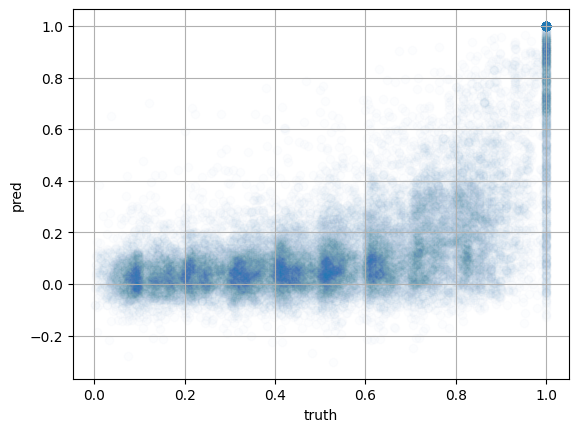

In [60]:
import matplotlib.pyplot as plt
plt.scatter(tanimoto_spec2vec, scores_spec2vec, alpha=0.01)
plt.ylabel('pred')
plt.xlabel('truth')
plt.grid()

In [61]:
original_tanimoto_spec2vec = tanimoto_spec2vec.copy()
original_scores_spec2vec=scores_spec2vec.copy()

In [62]:
tanimoto_spec2vec = [t for t in tanimoto_spec2vec if t is not None]
scores_spec2vec = [t for t in scores_spec2vec if t is not None]

In [63]:
tanimoto_spec2vec_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_spec2vec]
scores_spec2vec= [s if s>0 else 0 for s in scores_spec2vec ]

tpr: [0.         0.06857045 0.09233926 ... 0.93040356 0.93040356 1.        ]
fpr: [0.         0.         0.         ... 0.76259419 0.76267886 1.        ]


(array([0.        , 0.06857045, 0.09233926, ..., 0.93040356, 0.93040356,
        1.        ]),
 array([0.        , 0.        , 0.        , ..., 0.76259419, 0.76267886,
        1.        ]))

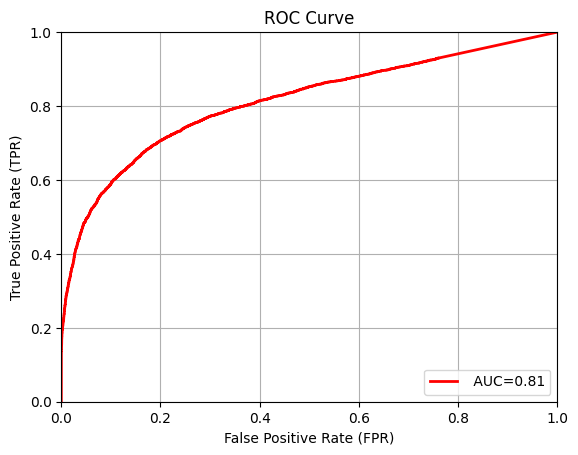

In [64]:
Plotting.plot_roc_curve(tanimoto_spec2vec_binary, 
                        scores_spec2vec)

In [65]:
spearman_spec2vec = spearmanr(tanimoto_spec2vec, scores_spec2vec)

## MS2DEEPSCORE

In [112]:
similarity_ms2 = MS2DeepScoreComparison.get_ms2deepscore_similarity(model_ms2d_file)

In [113]:
random_molecule_pairs_indexes = np.random.choice(range(0,len(molecule_pairs)), size=10000)

In [114]:
random_molecule_pairs_indexes[0]

26027

In [115]:
import tensorflow as tf
from datetime import datetime
start =datetime.now()
with tf.device('/device:CPU:0'):
    tanimotos_ms2, scores_ms2 = MS2DeepScoreComparison.compute_ms2deepscore(molecule_pairs, 
                        random_molecule_pairs_indexes, 
                        original_spectrum_match_hash, 
                        target_hashes_subset,
                        similarity_ms2)
end = datetime.now()

print(f'total seconds {(end-start).total_seconds()}')

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1697.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2352.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 925.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17050.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 654.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7108.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1133.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1303.79it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3486.54it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 243.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3028.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4064.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5096.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 953.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5084.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18641.35it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 735.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5108.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3575.71it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1766.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2949.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2779.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4583.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 329.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2041.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1631.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1526.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3986.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13617.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1669.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1670.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2525.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1798.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 330.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1703.62it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1068.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4405.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4181.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3799.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3890.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18724.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4258.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1219.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5645.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2814.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4017.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 189.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1246.82it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 925.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1200.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2799.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4696.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1288.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 476.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2375.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1850.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7231.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3498.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3437.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 151.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1231.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7061.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1672.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1723.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1776.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4815.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3799.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3788.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4002.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6831.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 778.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4112.06it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1224.26it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1521.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 739.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4288.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1026.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1689.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7281.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1903.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3816.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3368.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5825.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3983.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2257.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4080.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1195.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1506.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 566.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3744.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 215.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1404.19it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3637.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4100.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 17ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3806.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 981.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4364.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2824.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 638.60it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3379.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1548.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 716.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1608.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4275.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2150.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2570.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4481.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3572.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1286.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2207.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4100.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3938.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6523.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4782.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 190.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2624.72it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1557.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 368.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1621.30it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3788.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3226.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1342.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3872.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 733.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4068.19it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3953.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1039.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7653.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1432.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4539.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 152.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1012.14it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4369.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2559.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1207.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 968.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 853.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1567.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3622.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 881.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1227.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1949.93it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 194.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1179.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1485.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4655.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3533.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2657.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2091.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 728.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5121.25it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3276.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2321.14it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3289.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 603.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2216.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2272.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4675.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1371.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2105.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 386.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2364.32it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 704.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2816.86it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2688.66it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3377.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3125.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 227.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2603.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3908.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4017.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4624.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3986.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3390.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1572.67it/s]

1/1 [==============================] - 0s 16ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1751.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6355.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1410.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1474.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

1/1 [==============================] - 0s 14ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4328.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4165.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 626.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3721.65it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4350.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 731.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5017.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2652.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18641.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4364.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4165.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4405.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7182.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4215.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 982.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5518.82it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1472.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3521.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 546.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3125.41it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 388.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1919.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 18ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18315.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 766.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4080.06it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 187.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2369.66it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3146.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 394.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2898.62it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 869.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1788.62it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1244.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1146.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3548.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5084.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 919.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4744.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 719.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3650.40it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 814.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3584.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 714.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 341.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1501.18it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3979.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1721.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7332.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3688.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2105.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4310.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1533.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1639.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4116.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1666.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1522.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1754.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 401.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1835.58it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1118.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3609.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 863.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4017.53it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9489.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2178.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3086.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 362.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2451.38it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1212.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3125.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4048.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5577.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1646.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29746.84it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2101.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4387.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3679.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4500.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1505.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 242.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1757.14it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2863.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 964.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2232.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5133.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1721.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1747.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5384.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1286.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7854.50it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3013.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4905.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3919.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 988.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4588.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1280.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 736.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3609.56it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3506.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3830.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8594.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3097.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4634.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3908.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1270.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1369.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3509.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 17ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 868.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3279.36it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3637.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3521.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1196.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6241.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1426.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1552.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7157.52it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1644.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 793.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 214.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1186.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 191.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1841.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2931.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5737.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7423.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1964.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1129.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 875.64it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3387.97it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 788.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4563.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7206.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9404.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 683.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4410.41it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6678.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 915.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4346.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 737.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3788.89it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1600.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2951.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4258.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 563.30it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3010.99it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2288.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4341.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4946.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1582.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1278.75it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3758.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2353.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4419.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4032.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1187.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2978.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 211.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2439.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1745.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3964.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3498.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1163.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4733.98it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 627.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3530.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1046.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3292.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2872.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2122.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3226.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3844.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1058.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1195.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1249.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3435.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4744.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1714.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3297.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 185.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1302.17it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1582.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1995.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 205.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2092.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2673.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2761.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 184.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2420.26it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 345.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2122.62it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16844.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 488.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2416.07it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 613.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3344.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2779.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5793.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4405.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 443.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2644.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 18ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4185.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2119.41it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 220.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2906.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 954.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 731.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4202.71it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1118.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3216.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4013.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1911.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4364.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6909.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2159.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4064.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2624.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 587.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3172.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 845.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4032.98it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4346.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 168.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1066.98it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22429.43it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2398.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 193.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2746.76it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8594.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2062.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3872.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1250.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1049.36it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7913.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 139.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1180.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4328.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10591.68it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1565.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2173.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 992.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1597.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5256.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 604.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3355.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1095.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3775.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3059.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1470.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1141.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6087.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1148.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2268.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2666.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1548.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1119.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 159.29it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 905.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 279.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2262.30it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 177.18it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 696.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1239.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 269.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1292.15it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5607.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18641.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1760.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7423.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1394.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 815.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4080.06it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1432.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3088.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1298.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3919.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3919.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7281.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5047.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1090.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3744.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2096.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4604.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6069.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1594.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1416.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1334.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3410.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2723.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3256.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3938.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 345.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1145.36it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 287.36it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2252.58it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1127.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5753.50it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3463.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18641.35it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17050.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18641.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6223.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4116.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 189.64it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1360.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2941.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4364.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2452.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4315.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6831.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 17ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3423.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 201.69it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1083.52it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3533.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3437.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 799.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3653.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4634.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 160.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1757.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 977.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1912.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 683.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4275.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3206.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1216.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3758.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1222.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4165.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2457.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 689.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4132.32it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4549.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 875.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 758.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3460.65it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 841.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3125.41it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 686.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4350.94it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4549.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2525.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1110.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1161.54it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3483.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4275.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 17ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4529.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3705.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 889.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1119.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1160.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6743.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10381.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3923.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16844.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1065.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3813.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1615.06it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3165.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 580.69it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2843.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1124.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12446.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3597.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1980.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3289.65it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 678.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4144.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4185.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4258.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1942.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1572.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 739.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4755.45it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3415.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2409.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 725.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 692.02it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3059.30it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 452.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2208.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1137.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4048.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3415.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4946.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3125.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2054.02it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3165.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33288.13it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4017.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2841.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 544.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3146.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1010.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4258.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 872.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1254.28it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1149.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6355.01it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1079.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3934.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3788.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 163.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1842.03it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5398.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3637.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


1/1 [==============================] - 0s 19ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2078.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2015.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6636.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8594.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 747.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6721.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3088.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1073.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3847.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7913.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5577.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8019.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 423.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3010.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1538.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1945.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1234.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3802.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3177.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1211.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4198.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 161.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2702.52it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3415.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 693.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 212.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2768.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2114.06it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4181.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 966.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 707.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4112.06it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 568.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2857.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2519.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 179.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2319.86it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1176.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 208.64it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2006.84it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 164.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1592.37it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4315.13it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1805.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2272.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29746.84it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1845.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 301.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1479.47it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3412.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1686.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2414.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 504.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2908.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4549.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2882.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2283.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 739.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4275.54it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7423.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4782.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4350.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3204.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1063.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5562.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3236.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4219.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2444.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9404.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3721.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2631.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2462.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2236.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1476.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3968.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3334.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1552.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 825.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1642.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4391.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4017.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 733.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1747.63it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1903.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1628.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1081.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4364.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1872.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30615.36it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 204.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1528.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7653.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2015.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2362.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1769.75it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5398.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 194.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2493.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4258.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2164.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4364.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3844.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 979.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6087.52it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1250.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 308.36it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2159.79it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2326.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1163.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1904.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4760.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1848.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 359.07it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2291.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5108.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2123.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2968.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2309.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10591.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1831.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1679.74it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 861.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 522.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2646.25it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1147.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1694.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1680.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1145.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3637.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3983.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1342.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 925.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4707.41it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22429.43it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1694.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4782.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1751.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2839.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4905.62it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4100.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3609.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4017.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1391.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1708.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 896.60it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7231.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4624.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3968.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1533.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2646.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 687.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4519.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3118.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1004.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6069.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1123.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4084.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 959.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1273.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3204.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3146.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4429.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22429.43it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3358.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 640.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3637.73it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8594.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1322.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4029.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1060.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4624.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1052.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18724.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2976.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3572.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2519.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14563.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 157.15it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 872.00it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4116.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5737.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3266.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2438.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1726.76it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4215.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 399.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1911.72it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2087.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 753.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4275.54it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 210.54it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2584.29it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3647.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4002.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4588.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 18ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 505.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4032.98it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1407.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1147.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5504.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22429.43it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4419.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6743.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1555.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3650.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 522.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3279.36it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3597.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18315.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 17ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10485.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4013.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1175.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22429.43it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4675.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3536.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2652.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2597.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3204.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2011.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3788.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4405.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3872.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7281.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 285.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1512.55it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1712.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 441.74it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2499.59it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 925.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 417.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1834.78it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5121.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 676.06it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1625.70it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4198.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29746.84it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 916.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4529.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1548.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2753.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 980.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 151.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1131.46it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2131.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 884.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4100.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4064.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2003.01it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1582.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 761.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4288.65it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1101.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1640.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2007.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1685.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2371.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3435.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 721.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 235.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1200.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5384.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 886.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3059.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1067.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 350.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1918.71it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 909.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4609.13it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 513.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3934.62it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3968.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3594.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 613.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4198.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2305.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1305.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 189.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1942.71it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 403.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1815.72it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1930.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1736.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9489.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1102.60it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4219.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 579.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3584.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7231.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 512.06it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3675.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1369.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5518.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4068.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1191.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 991.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 734.30it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 224.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2880.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4563.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 352.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2549.73it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 243.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2369.66it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4165.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 907.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4100.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 952.60it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2087.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3472.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2341.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5398.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4136.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1283.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 733.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3460.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1106.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3248.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3557.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 767.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3771.86it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3066.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2427.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10485.76it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 781.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 777.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2062.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 683.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1883.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4848.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2062.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1510.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 242.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1165.41it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 856.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4369.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1748.36it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4202.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1552.30it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 445.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2298.25it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4017.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1093.98it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.24it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 975.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6786.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5133.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 218.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4036.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2136.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 482.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2501.08it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 771.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1567.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1675.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 211.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2832.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3410.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1689.21it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5096.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13443.28it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3153.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6087.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1814.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1333.64it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6316.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5121.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9489.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3037.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2866.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1623.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2570.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11459.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1377.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1461.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6260.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6241.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 633.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4410.41it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 603.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2058.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1032.06it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3533.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 196.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1501.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3876.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7157.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 780.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5084.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3919.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 171.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1822.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 647.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4324.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2278.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8594.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 384.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3002.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 962.66it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3498.17it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1851.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1842.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1655.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1430.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33288.13it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4568.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2036.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1582.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1117.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 862.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 189.64it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2908.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 605.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2299.51it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6260.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3890.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1381.07it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18641.35it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9039.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1703.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 666.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 895.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3435.14it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4696.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2050.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 139.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1065.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 159.13it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1657.83it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2872.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6523.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 217.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1776.49it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1086.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1428.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5753.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 682.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4332.96it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 689.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3300.00it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1205.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7157.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1194.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1131.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2096.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 168.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2071.26it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 433.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2468.69it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33288.13it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2149.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3949.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8019.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4198.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 899.29it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4905.62it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5096.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1314.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4860.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4258.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3379.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1442.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4382.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 808.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4116.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 871.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1709.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4860.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22429.43it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5562.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3986.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1754.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 375.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1811.01it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29746.84it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 918.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5133.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4696.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3246.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3226.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4447.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 739.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3287.07it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1496.90it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1941.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2657.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5940.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10356.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1007.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1138.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3858.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1832.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2212.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 970.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 926.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1009.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5940.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1285.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8665.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3826.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7854.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3412.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1215.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1261.07it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2216.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1149.75it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1282.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4144.57it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2993.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1597.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1098.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2119.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 607.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3819.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6034.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23563.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33026.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2739.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 593.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3560.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23563.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 581.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3137.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1167.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 590.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4181.76it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4032.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 371.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2709.50it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2826.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3518.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1644.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1531.33it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1742.54it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4675.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4096.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32513.98it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3279.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3862.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9489.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3557.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1151.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1349.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 779.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 179.40it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.61it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4946.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4905.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1256.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5548.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3216.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2050.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1141.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2824.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2414.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6034.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4405.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1218.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1505.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3844.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2421.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3446.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1933.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4185.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1700.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10485.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4315.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8594.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 649.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4100.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4332.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 149.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1522.43it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2391.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2624.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2570.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30615.36it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1663.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1381.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33288.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 204.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1045.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 366.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3048.19it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 309.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2458.56it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3761.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5309.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 883.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11459.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1912.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5269.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3718.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 689.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4447.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4064.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1672.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 198.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1529.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2104.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1837.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1141.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5548.02it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4387.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 674.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4017.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2462.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3440.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1295.74it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1012.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33554.43it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 492.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3039.35it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 812.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4549.14it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6786.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1559.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 283.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1273.70it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 457.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1996.34it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4655.17it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 598.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3663.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3637.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 544.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2584.29it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1190.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 233.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1503.33it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3068.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4760.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 846.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4324.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1271.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3141.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 183.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1130.84it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 594.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3415.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11459.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29746.84it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 954.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4777.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1096.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 797.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1122.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5269.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5269.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1786.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 207.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2207.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11848.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2177.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6678.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1459.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1499.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3437.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3057.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2551.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5190.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1971.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9039.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1742.54it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1038.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1156.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1292.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 643.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4096.00it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 647.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3560.53it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6452.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6636.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1071.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 927.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1576.81it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5121.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13400.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4136.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18724.57it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7108.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3569.62it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 375.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2811.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4782.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 663.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3548.48it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4132.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3545.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 872.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4529.49it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1088.02it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5907.47it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1792.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1295.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3986.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2178.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2032.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2376.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 630.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6636.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4080.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 581.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3826.92it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4837.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6955.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2651.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4052.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3460.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3472.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 987.13it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4369.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1069.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3872.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1276.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 361.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2814.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3134.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3019.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 937.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3788.89it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1334.92it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2202.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1526.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 612.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3486.54it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5121.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5489.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3862.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14563.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5660.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2792.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3758.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 959.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 703.74it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2023.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1043.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 859.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6241.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1474.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1100.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 813.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4275.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1575.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5384.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1388.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2369.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1791.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 254.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1107.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1569.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 963.54it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1283.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18315.74it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7423.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8665.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1353.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3788.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2178.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2296.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 688.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4002.20it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3146.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1852.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2995.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 627.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4013.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10356.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2763.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4310.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1754.94it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4029.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3509.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1602.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 679.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3637.73it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1151.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 811.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2221.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3498.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4369.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2236.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9489.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3998.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 919.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 800.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1394.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7157.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3472.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1382.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6223.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2142.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4048.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2462.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 524.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1347.78it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 211.69it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1083.52it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1176.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3637.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4549.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 158.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1207.69it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1175.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32017.59it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1142.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4815.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1585.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4524.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4382.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6034.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1886.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9404.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16844.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3701.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3483.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4529.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1572.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10459.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2746.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1886.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4981.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3536.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2004.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 391.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2392.64it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9489.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1226.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1414.13it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1801.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4583.94it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23431.87it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1358.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3509.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1984.06it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2385.84it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4116.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1134.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 569.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2811.20it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 586.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3675.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 860.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1308.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6523.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2664.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5645.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2839.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12446.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4165.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4563.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1622.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5940.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 756.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 645.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2385.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1149.75it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6316.72it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 758.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4712.70it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4549.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 187.66it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2624.72it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6223.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 840.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1923.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1995.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 903.36it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1916.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7108.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3125.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2219.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4181.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1054.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 948.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2718.28it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1098.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5577.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1633.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 868.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2114.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3086.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1065.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1173.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1290.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2108.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5518.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4848.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2063.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1772.74it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 932.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2213.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2462.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7108.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 881.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6034.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4364.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 419.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2931.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2238.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1398.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5133.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2882.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3919.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12945.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1931.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3968.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 542.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4032.98it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1751.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1745.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 165.62it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1047.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3679.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4696.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3788.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7108.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 687.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1547.71it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2816.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1837.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 172.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1508.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4604.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 286.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3289.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33288.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1400.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3983.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6034.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3569.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5645.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1116.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4116.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1418.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3175.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 642.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3634.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3068.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4161.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1531.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5691.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3949.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2033.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 224.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2078.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 900.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 942.54it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 664.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7206.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1776.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 221.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2045.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1805.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3010.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8594.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1462.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7598.38it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 421.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2623.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1865.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 174.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2545.09it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 439.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3095.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1019.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7913.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 147.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1168.33it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1444.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 933.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1012.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3650.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4169.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8525.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 17ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3492.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1038.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2174.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 538.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3050.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1347.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1769.75it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1039.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2314.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5295.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1228.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1686.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23431.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1173.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4832.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1210.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3858.61it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15087.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1213.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2531.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3165.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 694.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 777.73it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4782.56it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1714.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4588.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14563.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7913.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1937.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3971.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1290.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2611.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1987.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1564.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 538.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2864.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3116.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28339.89it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1453.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2183.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1145.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 524.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2841.67it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 964.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5577.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3744.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2207.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3923.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 959.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2236.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10485.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2704.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10591.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4405.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4549.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3002.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1428.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1647.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1443.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 627.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3437.95it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 961.33it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4185.93it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3609.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3182.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2375.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13400.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13231.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1985.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22429.43it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 730.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5691.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1730.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2681.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2020.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5645.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 945.30it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2246.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 765.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 174.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2288.22it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 735.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2474.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1477.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1406.54it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 367.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1723.92it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1398.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 735.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4240.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1291.75it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5047.30it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1984.06it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1529.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 819.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3618.90it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9279.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 203.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1541.46it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 680.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3492.34it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 753.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4568.96it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1293.74it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5753.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4424.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3775.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5398.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2331.46it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1887.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2906.66it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2247.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1049.36it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3788.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1869.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4744.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 803.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2605.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2495.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4505.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1424.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 780.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2231.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4215.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2201.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1612.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1599.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7854.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3030.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1516.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 344.36it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2557.50it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1570.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11848.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4563.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2090.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1125.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3622.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 179.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2299.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1522.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8525.01it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4048.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5737.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 556.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3872.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 464.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2585.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2083.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1347.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1068.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4328.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2169.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3483.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 381.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2792.48it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10356.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1949.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13443.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33554.43it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 763.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4215.38it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2872.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2189.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1630.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11459.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3663.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2983.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2723.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3692.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3446.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 14ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1319.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 791.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7157.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1923.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33554.43it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 17ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2045.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5047.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1727.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 945.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2890.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5753.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5983.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 925.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3971.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6482.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 646.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4563.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4634.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1984.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2257.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 208.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4068.19it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1127.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3986.98it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5907.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1515.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3672.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13617.87it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1738.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1277.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1440.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3398.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5108.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 638.60it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4369.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1422.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5562.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1479.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4882.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5184.55it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6105.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5384.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3521.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 547.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4975.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 658.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4275.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1820.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 177.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1481.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3498.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4568.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6594.82it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1678.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 169.30it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1626.33it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5645.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 193.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1315.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2763.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3320.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1794.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5047.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 654.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4219.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1251.66it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1209.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 981.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2457.12it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 817.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2611.65it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11522.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1227.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3666.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1396.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6278.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5047.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 393.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3331.46it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 192.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1533.57it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4675.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2799.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5890.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6061.13it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 734.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2673.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2398.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10485.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1779.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2824.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2444.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5504.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4583.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 757.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3659.95it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 708.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4128.25it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4080.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8525.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4288.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5622.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3986.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1183.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 484.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3077.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 971.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4696.87it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2216.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1935.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4185.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1937.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4629.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14563.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 992.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5108.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 983.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5518.82it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1286.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7182.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5159.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1617.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2941.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4563.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 877.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4981.36it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1176.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5907.47it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6052.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14027.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 782.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1700.85it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3721.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5096.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2007.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32513.98it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4341.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4096.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 232.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1210.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8081.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12087.33it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1269.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7133.17it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1706.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3435.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4529.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1107.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7307.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3214.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1050.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2874.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 905.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5121.25it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 582.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1933.75it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 215.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2678.36it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2597.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14122.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2922.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3336.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4324.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6743.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11715.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1028.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5282.50it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1039.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1574.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6355.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2149.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2331.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3905.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11459.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6462.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 196.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3609.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9198.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 726.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2688.66it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2104.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2584.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6278.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1956.30it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 184.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1714.76it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1294.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1760.09it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 216.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3355.44it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2702.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 743.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4382.76it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 154.75it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1600.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4084.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10951.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4219.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 820.32it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4650.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14979.66it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 309.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1675.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3355.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4583.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7681.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1430.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8525.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1731.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4462.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3435.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1303.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 212.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2325.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5236.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2947.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3634.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4288.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4804.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1594.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 356.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2362.99it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4328.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1739.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4165.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3748.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1379.25it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3758.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1021.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5053.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2597.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1105.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1180.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2608.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4240.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4387.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 248.02it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1329.84it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 209.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3116.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2000.14it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 374.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1960.87it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2847.46it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7397.36it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5229.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12520.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9576.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11848.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1984.06it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 212.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1285.41it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4466.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 804.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3258.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.55it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5077.85it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1519.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2577.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7049.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6168.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2028.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2054.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2071.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4568.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2141.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3672.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1814.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9868.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 759.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1168.66it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1254.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4346.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2015.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2519.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 204.54it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1123.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5562.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31300.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 796.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5370.43it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances:   0%|                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2373.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3744.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4258.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 725.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3998.38it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4116.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3799.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12710.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17772.47it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1030.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 922.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4181.76it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.58it/s]

Create BinnedSpectrum instances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 982.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7231.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5809.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1402.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5841.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3506.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4675.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4310.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7244.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1565.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2284.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2674.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1811.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 160.90it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1307.04it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4219.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13842.59it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10485.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4148.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1529.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3320.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5753.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5706.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2632.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4928.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1242.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6132.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1085.48it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4583.94it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6978.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2874.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1410.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 955.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1949.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3300.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3983.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 246.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1129.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 654.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3731.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3953.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 471.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2995.93it/s]

1/1 [==============================] - 0s 15ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1560.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6700.17it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 575.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4236.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 178.07it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1594.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15827.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7653.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 861.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1766.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1093.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4240.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 653.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3292.23it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9489.38it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3297.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1880.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2746.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5957.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6177.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6335.81it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1116.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5592.41it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1457.37it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6096.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4739.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 652.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4096.00it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 316.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1980.31it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 603.58it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2676.65it/s]

1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 672.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3435.14it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 887.31it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3908.95it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3269.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 493.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2770.35it/s]

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6765.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4190.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4782.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 17ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5468.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8355.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3287.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15420.24it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4382.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 688.15it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 724.53it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4634.59it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5084.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 17ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 668.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1108.43it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6316.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3653.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4466.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 162.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1811.01it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9383.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6374.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14217.98it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6657.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1182.16it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6250.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2801.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3998.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11244.78it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1237.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12300.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4583.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4253.86it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7449.92it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5256.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4161.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3536.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13025.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6204.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9362.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 918.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5874.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8192.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4809.98it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8338.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 747.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3968.12it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 175.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1510.37it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3718.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10591.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32263.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 817.13it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1760.09it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3692.17it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11459.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4466.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 924.26it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4882.78it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6898.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3744.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16448.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4169.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16912.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2577.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1161.54it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18236.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10837.99it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1420.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2985.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1390.68it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5607.36it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10782.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8490.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5071.71it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6213.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2347.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 581.17it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2896.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10866.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7061.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 996.04it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4609.13it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 948.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5023.12it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10330.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7145.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10979.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5461.33it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4405.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1383.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7710.12it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2807.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20262.34it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1239.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12446.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5817.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23431.87it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1026.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 863.74it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4826.59it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1362.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3775.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23431.87it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1792.44it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7989.15it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6288.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 530.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2976.79it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1333.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4854.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6241.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22919.69it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1162.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1550.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2746.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3572.66it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4152.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10180.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6533.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 382.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2949.58it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 283.71it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1170.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3744.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14926.35it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 749.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3584.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5915.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 219.45it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3165.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5384.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6492.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20360.70it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 601.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4310.69it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20971.52it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8905.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3021.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8128.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5133.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3701.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13706.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5882.61it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19152.07it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6223.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9915.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2357.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13662.23it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4032.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17050.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8612.53it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4899.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8683.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19328.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4999.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11125.47it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9118.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4466.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7476.48it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 182.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1499.57it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2183.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1077.40it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6364.65it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6141.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12865.96it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12826.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 600.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3659.95it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 747.91it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4013.69it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7598.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11781.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29330.80it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 527.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3054.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5497.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2681.78it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2080.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 986.20it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5645.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 373.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1709.17it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 18ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7557.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1151.96it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3688.92it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7037.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16070.13it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14768.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1276.80it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3788.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5017.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7002.18it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 417.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2288.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12157.40it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8405.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7358.43it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4064.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3214.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31068.92it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12671.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9986.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13486.51it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4568.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2673.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6017.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5349.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1472.72it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5683.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1706.39it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 967.99it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5722.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11881.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8004.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4634.59it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8144.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9686.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6574.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6543.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3785.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7825.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12985.46it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1288.57it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6584.46it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4410.41it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15650.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5518.82it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23696.63it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3524.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 758.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3788.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9776.93it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5127.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10512.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12483.05it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7767.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4624.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13189.64it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5652.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15196.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8793.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 931.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6615.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30174.85it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5440.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 755.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4670.72it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10010.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8322.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17331.83it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8112.77it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]


1/1 [==============================] - 0s 12ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4782.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7928.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7194.35it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25575.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7503.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11214.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5584.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12787.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28728.11it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3876.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 976.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4766.25it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3287.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27776.85it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2262.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1129.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]


1/1 [==============================] - 0s 19ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3998.38it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7752.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7943.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6413.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2293.22it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6808.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13231.24it/s]


1/1 [==============================] - 0s 27ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 817.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4185.93it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 913.19it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1412.70it/s]

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 931.24it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3584.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8289.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1222.12it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2198.27it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9238.56it/s]

1/1 [==============================] - 0s 14ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1018.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5152.71it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16384.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5675.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20068.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4837.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7463.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8630.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3509.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11155.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7695.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7516.67it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4271.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]


1/1 [==============================] - 0s 17ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5924.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5555.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7530.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 170.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1216.45it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28532.68it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14873.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27594.11it/s]


1/1 [==============================] - 0s 19ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6626.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7084.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15141.89it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 193.38it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1521.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1448.81it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7096.96it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3214.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5777.28it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1503.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6932.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9039.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8559.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 903.36it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4048.56it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9020.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9642.08it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9510.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3095.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11650.84it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4447.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9157.87it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6668.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16194.22it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11275.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24818.37it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9731.56it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4350.94it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4013.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4032.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13148.29it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8422.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13934.56it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5526.09it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 702.21it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4100.00it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5398.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25420.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5949.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1018.28it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12228.29it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26214.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1451.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5322.72it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8208.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10230.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7157.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17924.38it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14074.85it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5203.85it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4744.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15592.21it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9822.73it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19508.39it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8272.79it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5433.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7570.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11008.67it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5753.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16578.28it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21845.33it/s]


1/1 [==============================] - 0s 16ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4443.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 172.74it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1230.36it/s]

1/1 [==============================] - 0s 14ms/step




Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7256.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16320.25it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11096.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27235.74it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3557.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 846.65it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3799.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4788.02it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13357.66it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16131.94it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5714.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9078.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12633.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]

1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5377.31it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14716.86it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17476.27it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4332.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2352.39it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1904.77it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8756.38it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19878.22it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9619.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22795.13it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4718.00it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8830.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5315.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15363.75it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8388.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4951.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13530.01it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8867.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8848.74it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11335.96it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30393.51it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7410.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 649.88it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4002.20it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13888.42it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4447.83it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18808.54it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7157.52it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14513.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8542.37it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7738.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1027.76it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6442.86it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8050.49it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21620.12it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7626.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5029.14it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9258.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 15ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11915.64it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8256.50it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 406.50it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1560.38it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 402.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1572.08it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9425.40it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25731.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4382.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9000.65it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21732.15it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4691.62it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7913.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5289.16it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8943.08it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21183.35it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10894.30it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17623.13it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13231.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8774.69it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10727.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10305.42it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10754.63it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29537.35it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4860.14it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11491.24it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1434.93it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10645.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10407.70it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11397.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9532.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10433.59it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26379.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 308.84it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2198.27it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6326.25it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8065.97it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23301.69it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19972.88it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11618.57it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]


1/1 [==============================] - 0s 18ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6842.26it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19239.93it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5269.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8701.88it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4733.98it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13315.25it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1602.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7810.62it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10538.45it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1461.94it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7345.54it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1811.79it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5991.86it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4922.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10618.49it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 253.66it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1172.25it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10131.17it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25115.59it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7884.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17189.77it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1232.89it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6403.52it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1610.10it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]


1/1 [==============================] - 0s 15ms/step



Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 567.87it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2995.93it/s]

Spectrum binning: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5210.32it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9597.95it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20763.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5398.07it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22671.91it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5412.01it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17848.10it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10034.22it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9799.78it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18477.11it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22310.13it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7294.44it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11848.32it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27060.03it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9892.23it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5262.61it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15887.52it/s]

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5405.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12372.58it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23563.51it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1752.01it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9177.91it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11748.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4293.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11366.68it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2104.52it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]


1/1 [==============================] - 0s 16ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7639.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21290.88it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8176.03it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9098.27it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23172.95it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10205.12it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1305.82it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6887.20it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 18ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3175.10it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19599.55it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4387.35it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7869.24it/s]


1/1 [==============================] - 0s 12ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3075.00it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6026.30it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6710.89it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14665.40it/s]


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4382.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14266.34it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6754.11it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20867.18it/s]


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9341.43it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12052.60it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10106.76it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17549.39it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6797.90it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16710.37it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12336.19it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24385.49it/s]


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9709.04it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6297.75it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22192.08it/s]


1/1 [==============================] - 0s 13ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5178.15it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18558.87it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6944.21it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19691.57it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1326.47it/s]

Create BinnedSpectrum instances: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6853.44it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 7584.64it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21399.51it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6990.51it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17260.51it/s]

Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5849.80it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23831.27it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step



Spectrum binning: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8473.34it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24966.10it/s]

Spectrum binning: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10082.46it/s]

Create BinnedSpectrum instances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16644.06it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [09:33<00:00, 17.44it/s]

total seconds 573.276368


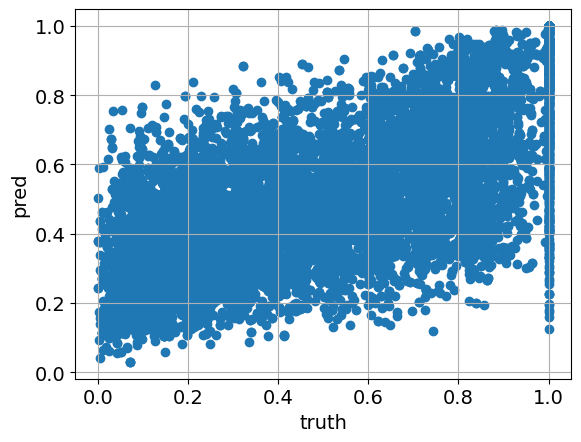

In [116]:
import matplotlib.pyplot as plt
plt.scatter(tanimotos_ms2, [s if s > 0 else 0 for s in scores_ms2], alpha=1)
plt.ylabel('pred')
plt.xlabel('truth')
plt.grid()

In [117]:
original_tanimotos_ms2 = tanimotos_ms2.copy()
original_scores_ms2=scores_ms2.copy()

In [118]:
tanimotos_ms2 = [t for t in tanimotos_ms2 if t is not None]
scores_ms2 = [t for t in scores_ms2 if t is not None]

In [119]:
tanimotos_ms2_binary= [1 if t>THRESHOLD_ANALOG else 0 for t in tanimotos_ms2]
scores_ms2=[s if s>0 else 0 for s in scores_ms2]

In [120]:
len(scores_ms2)

10000

In [121]:
sum(np.array(tanimotos_ms2_binary)>0)

2985

In [122]:
np.sum((np.array(scores_ms2) > 0 )& (np.array(tanimotos_ms2_binary)>0))

2985

tpr: [0.         0.04924623 0.04991625 ... 1.         1.         1.        ]
fpr: [0.         0.         0.         ... 0.99914469 0.99957234 1.        ]


(array([0.        , 0.04924623, 0.04991625, ..., 1.        , 1.        ,
        1.        ]),
 array([0.        , 0.        , 0.        , ..., 0.99914469, 0.99957234,
        1.        ]))

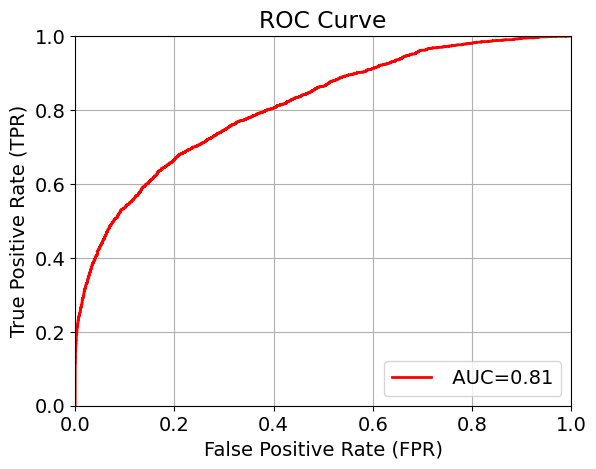

In [123]:

Plotting.plot_roc_curve(tanimotos_ms2_binary, scores_ms2)

In [124]:
a=5

In [125]:
spearman_ms2 = spearmanr(tanimotos_ms2, scores_ms2)

## Our model

In [80]:
from src.transformers.sklearn_model import SklearnModel

In [81]:
#temp_molecule_pairs= MolecularPairsSet(spectrums= molecule_pairs.spectrums, 
#                                      indexes_tani =molecule_pairs.indexes_tani)
temp_molecule_pairs = molecule_pairs

In [82]:
#model = Embedder.load_from_checkpoint(
 #           checkpoint_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS
#        )

In [86]:
model =SklearnModel(model_path=transformer_path, d_model=config.D_MODEL, n_layers=config.N_LAYERS)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using cosine library from Pytorch?: True


In [87]:
#next(iter(dataloader_test))

In [88]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] 

'1'

In [89]:
scores_trans=model.predict_from_molecule_pair(temp_molecule_pairs)

Preprocessing all the data ...


33719it [00:01, 20622.29it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26650/26650 [00:00<00:00, 116196.94it/s]


Preprocessing all the data ...


33719it [00:00, 80951.76it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)


In [90]:
temp_molecule_pairs

In [91]:
tanimoto_trans = [row[2] for row in temp_molecule_pairs.indexes_tani]

In [92]:
tanimoto_trans_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_trans]
scores_trans=[float(s) if s>0 else 0 for s in (scores_trans)]

In [93]:
scores_trans

[0.08612324297428131,
 0.06360644102096558,
 0.060925260186195374,
 0.26855361461639404,
 0.07861204445362091,
 0.03538829833269119,
 0.09530431777238846,
 0.09066888689994812,
 0.02490924671292305,
 0.08171206712722778,
 0.1739688515663147,
 0.08730070292949677,
 0.19117505848407745,
 0.08637115359306335,
 0.14167675375938416,
 0.06748735904693604,
 0.05292011797428131,
 0.06913232058286667,
 0.08775874972343445,
 0.13094714283943176,
 0.13483837246894836,
 0.22407175600528717,
 0.11820651590824127,
 0.06510519981384277,
 0.1026609018445015,
 0.35415157675743103,
 0.41485434770584106,
 0.12356039136648178,
 0.07312542200088501,
 0.12118987739086151,
 0.043814517557621,
 0.06533624976873398,
 0.0874650850892067,
 0.11429156363010406,
 0.0758923590183258,
 0.03976451978087425,
 0.09138210117816925,
 0.09966571629047394,
 0.06675353646278381,
 0.028144899755716324,
 0.03488009423017502,
 0.09109002351760864,
 0.09608197212219238,
 0.09069357067346573,
 0.22802650928497314,
 0.04910373315

In [94]:
tanimoto_trans

[0.09158416092395782,
 0.08464566618204117,
 0.0626223087310791,
 0.0873015895485878,
 0.09910912811756134,
 0.02777777798473835,
 0.09562398493289948,
 0.09163346886634827,
 0.017241379246115685,
 0.09698276221752167,
 0.08547008782625198,
 0.06925208121538162,
 0.041067760437726974,
 0.09963099658489227,
 0.03550295904278755,
 0.07000946253538132,
 0.022727273404598236,
 0.07019328325986862,
 0.09302325546741486,
 0.09163346886634827,
 0.09868421405553818,
 0.09728182852268219,
 0.08215661346912384,
 0.04752065986394882,
 0.08460845798254013,
 0.081471748650074,
 0.05000000074505806,
 0.09001956880092621,
 0.09745127707719803,
 0.0703125,
 0.009734513238072395,
 0.0833333358168602,
 0.09200000017881393,
 0.09529276937246323,
 0.06275303661823273,
 0.07002801448106766,
 0.08888889104127884,
 0.0747474730014801,
 0.06765899807214737,
 0.01587301678955555,
 0.06209849938750267,
 0.029891304671764374,
 0.08115942031145096,
 0.08930669724941254,
 0.06473594903945923,
 0.03442623093724251,

In [95]:
len(tanimoto_trans)

26650

In [96]:
len(scores_trans)

26650

In [97]:
spearman_trans = spearmanr(tanimoto_trans, scores_trans)
spearman_trans

SignificanceResult(statistic=0.8866587394410317, pvalue=0.0)

In [98]:
np.sum((np.array(scores_trans) > 0 )& (np.array(tanimoto_trans_binary)>0))

7995

tpr: [0.         0.0011257  0.00762977 ... 0.99987492 1.         1.        ]
fpr: [0.         0.         0.         ... 0.97732511 0.97732511 1.        ]


(array([0.        , 0.0011257 , 0.00762977, ..., 0.99987492, 1.        ,
        1.        ]),
 array([0.        , 0.        , 0.        , ..., 0.97732511, 0.97732511,
        1.        ]))

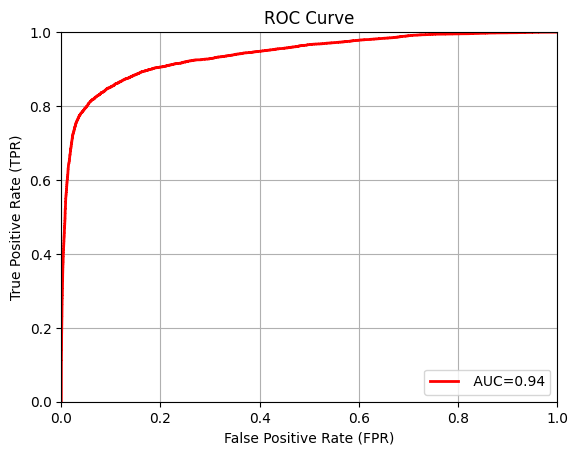

In [99]:
Plotting.plot_roc_curve(tanimoto_trans_binary, scores_trans)

## Compute modified cosine

In [100]:
from src.modified_cosine import ModCosine

In [101]:
modcos_similarity =ModCosine.get_mod_cosine()

In [102]:
tanimoto_modcos, scores_modcos= ModCosine.compute_scores_tanimoto(molecule_pairs, 
                                                                                preprocessed_spectrums, 
                                                                               target_hashes_subset, 
                                                                               modcos_similarity)

  4%|██████▉                                                                                                                                                                  | 1099/26650 [00:05<01:11, 355.64it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

  8%|█████████████▉                                                                                                                                                           | 2193/26650 [00:05<00:25, 952.51it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 12%|████████████████████▋                                                                                                                                                   | 3288/26650 [00:05<00:12, 1821.16it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 16%|███████████████████████████▌                                                                                                                                            | 4382/26650 [00:05<00:07, 2849.20it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 20%|██████████████████████████████████▍                                                                                                                                     | 5460/26650 [00:06<00:05, 3776.04it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 25%|█████████████████████████████████████████▌                                                                                                                              | 6588/26650 [00:06<00:04, 4574.39it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 29%|████████████████████████████████████████████████▌                                                                                                                       | 7705/26650 [00:06<00:03, 5042.24it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 33%|███████████████████████████████████████████████████████▌                                                                                                                | 8822/26650 [00:06<00:03, 5299.82it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 37%|██████████████████████████████████████████████████████████████▊                                                                                                         | 9967/26650 [00:06<00:03, 5511.49it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                 | 11126/26650 [00:07<00:02, 5652.10it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                          | 12269/26650 [00:07<00:02, 5638.24it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                   | 13415/26650 [00:07<00:02, 5687.54it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 14568/26650 [00:07<00:02, 5714.87it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 15715/26650 [00:07<00:01, 5713.84it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 16859/26650 [00:08<00:01, 5699.28it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 17996/26650 [00:08<00:01, 5638.28it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 19132/26650 [00:08<00:01, 5661.01it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 20265/26650 [00:08<00:01, 5646.45it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 21399/26650 [00:08<00:00, 5652.05it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 22547/26650 [00:09<00:00, 5697.98it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 23693/26650 [00:09<00:00, 5701.96it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 24826/26650 [00:09<00:00, 5396.92it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 25896/26650 [00:09<00:00, 5145.34it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26650/26650 [00:09<00:00, 2712.22it/s]

Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in spectrums
Some Nones in sp

In [103]:
original_tanimoto_modcos = tanimoto_modcos.copy()
original_scores_modcos=scores_modcos.copy()

In [104]:
tanimoto_modcos = [t for t in tanimoto_modcos if t is not None]
scores_modcos = [t for t in scores_modcos if t is not None]

In [105]:
len(scores_modcos)

17659

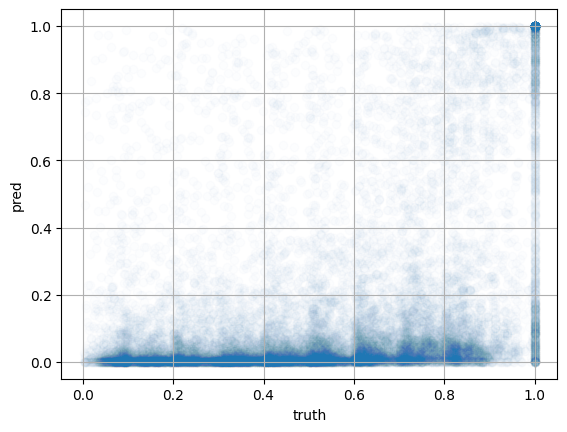

In [106]:
import matplotlib.pyplot as plt
plt.scatter(tanimoto_modcos, scores_modcos, alpha=0.01)
plt.ylabel('pred')
plt.xlabel('truth')
plt.grid()

In [107]:
tanimoto_modcos_binary=[1 if t>THRESHOLD_ANALOG else 0 for t in tanimoto_modcos]
scores_modcos= [s if s>0 else 0 for s in scores_modcos ]

tpr: [0.00000000e+00 1.70998632e-04 5.12995896e-04 ... 9.89740082e-01
 9.89740082e-01 1.00000000e+00]
fpr: [0.         0.         0.         ... 0.93506054 0.93607654 1.        ]


(array([0.00000000e+00, 1.70998632e-04, 5.12995896e-04, ...,
        9.89740082e-01, 9.89740082e-01, 1.00000000e+00]),
 array([0.        , 0.        , 0.        , ..., 0.93506054, 0.93607654,
        1.        ]))

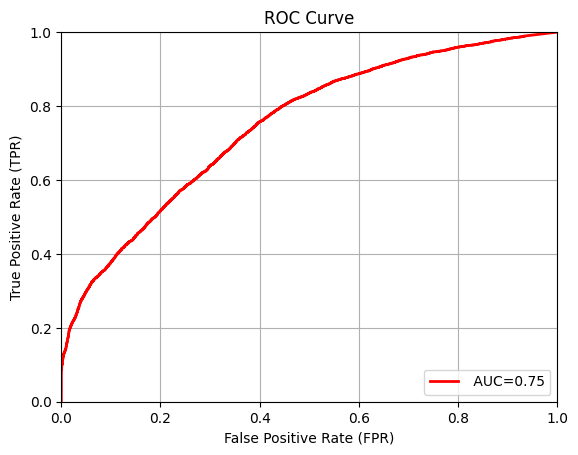

In [108]:
Plotting.plot_roc_curve(tanimoto_modcos_binary,scores_modcos)

In [109]:
len(scores_modcos)

17659

In [110]:
spearman_modcos = spearmanr(tanimoto_modcos, scores_modcos)

## Plot all results

tpr: [0.         0.0011257  0.00762977 ... 0.99987492 1.         1.        ]
fpr: [0.         0.         0.         ... 0.97732511 0.97732511 1.        ]
tpr: [0.         0.04924623 0.04991625 ... 1.         1.         1.        ]
fpr: [0.         0.         0.         ... 0.99914469 0.99957234 1.        ]
tpr: [0.         0.06857045 0.09233926 ... 0.93040356 0.93040356 1.        ]
fpr: [0.         0.         0.         ... 0.76259419 0.76267886 1.        ]
tpr: [0.00000000e+00 1.70998632e-04 5.12995896e-04 ... 9.89740082e-01
 9.89740082e-01 1.00000000e+00]
fpr: [0.         0.         0.         ... 0.93506054 0.93607654 1.        ]


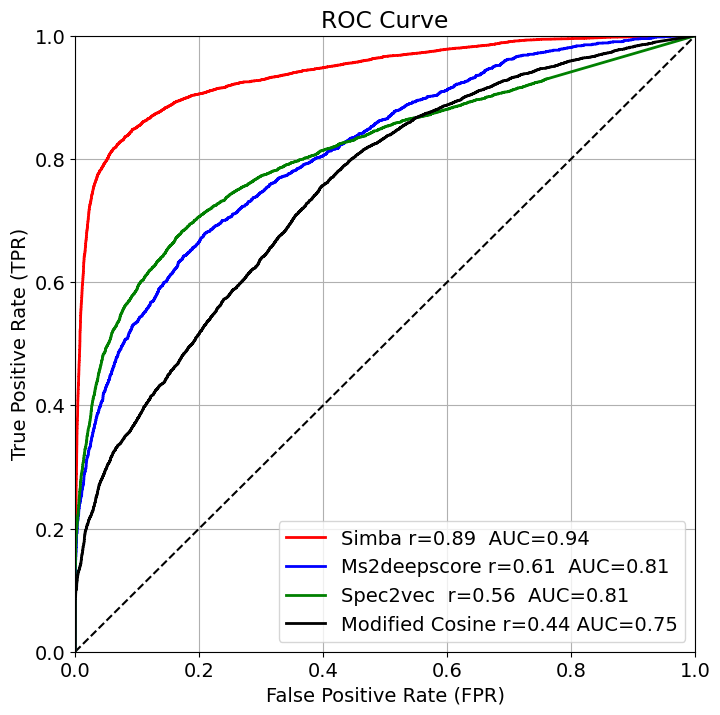

In [126]:
Plotting.plot_n_roc_curves(y_true_list= [tanimoto_trans_binary, tanimotos_ms2_binary, tanimoto_spec2vec_binary,  tanimoto_modcos_binary, ],
                           y_scores_list=[scores_trans, scores_ms2, scores_spec2vec, scores_modcos, ],
                           labels=[f'Simba r={spearman_trans[0]:.2f} ',
                                   f'Ms2deepscore r={spearman_ms2[0]:.2f} ', 
                                   f'Spec2vec  r={spearman_spec2vec[0]:.2f} ', 
                                   F'Modified Cosine r={spearman_modcos[0]:.2f}'],
                                   
                           colors = ['r','b','g', 'k'])
plt.grid()